### **Importing Libraries**

In [3]:
# Std Libraries...
import os
import re
import shutil
import string

# Data manipulation libraries...
import matplotlib.pyplot as pl
import numpy as np

# Deep-Learning libraries
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers as lyrs, optimizers as opts, losses


### **Downloading Data**

> **`Don't run this cell, it downloads data which is already done`**

In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(
    "aclImdb_v1", url,
    untar=True, cache_dir='.',
    cache_subdir=''
)

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
print(os.listdir(dataset_dir))


['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']


> #### **Checking a sample file**

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
print(os.listdir(train_dir))

sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())
    
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)


['labeledBow.feat', 'neg', 'pos', 'unsup', 'unsupBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']
Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


> **For data-preprocessing, it has to be passed onto library that expects a file structure like:**

* main_directory/
* ...class_a/
* ......a_text_1.txt
* ......a_text_2.txt
* ...class_b/
* ......b_text_1.txt
* ......b_text_2.txt

### **Loading Data For training**
> ##### **Dividing train data into training and validation data using `text_dataset_from_directory`**

In [6]:
### FunctionParameters ###
bs = 32
s = 42

# this is the trainig set...
RawTrainDataset = tfk.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=bs, seed=s,
    validation_split=0.2, subset='training'
)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


##### **Label `0` corresponds to `neg`**
##### **Label `1` corresponds to `pos`**


In [ ]:
# Looking into data

for txt_b, lbl_b in RawTrainDataset.take(1):
    print(f"Review:: {txt_b.numpy()[7]}")
    print(f"Label:: {lbl_b.numpy()[7]}\n\n")


In [8]:
# this is the validation set...
raw_val_ds = tfk.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=bs,
    validation_split=0.2,
    subset='validation',
    seed=s)


# getting ready the test set...
raw_test_ds = tfk.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=bs,
)


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### **Preparing Dataset for training**
> **Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer.**

* **`Standardization` refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset**
* **`Tokenization` refers to splitting strings into tokens (for example, splitting a sentence into individual words)**
* **`Vectorization` refers to converting tokens into numbers so they can be fed into a neural network**


> ##### **Defining a custom Standardization function**

In [9]:
# Turns out, default standardization cannot remove <HTML/> tags, 
# thus we need to create our own simple one.

def cstm_stdfn(data):
    lc = tf.strings.lower(data)
    # the operation below strinps out basic HTML
    formatted = tf.strings.regex_replace(lc, '<br />', '')
    return tf.strings.regex_replace(
        formatted, '[%s]' % re.escape(string.punctuation), ''
    )

> ##### **Creating a text-vectorization layer**

In [10]:
mx_fea = 10000 # dont know what for
slen = 250 # truncate sequences to exact sequence length!!

vec_layer = lyrs.TextVectorization(
    standardize= cstm_stdfn,
    max_tokens= mx_fea,
    output_mode= 'int',
    output_sequence_length= slen
)

> **Next, you will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.**

In [11]:
train_text = RawTrainDataset.map(lambda x, y: x)
print(train_text)
vec_layer.adapt(train_text)


<MapDataset shapes: (None,), types: tf.string>


In [12]:

# Testing the above layer with sample data to get insight on text pre-processing results!!

def vectorize(text, label):
    text = tf.expand_dims(input= text,axis= -1)
    return vec_layer(text), label

# Retrieving a batch (of 32 reviews and labels) from the dataset
(txt_b, lbl_b) = next(iter(RawTrainDataset))
first_txt, first_lbl = txt_b[0], lbl_b[0]
print("Printing out stuff!")
print(f"First Review:: {first_txt}")
print(f"Label(encoding):: {first_lbl}")
print(f"Sentiment:: {RawTrainDataset.class_names[first_lbl]}")
print("Vectorized review", vectorize(first_txt, first_lbl))


Printing out stuff!
First Review:: b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.'
Label(encoding):: 0
Sentiment:: neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  84,   17,  257,    2,  222,    1,  573,   30,  228,   10, 2416,
           1,   52,   23,   25,  427,  249,   12,  306,  279,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0, 

> **You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.**

In [13]:
print(f"25 ==> {vec_layer.get_vocabulary()[1213]}")
print(f"2416 ==> {vec_layer.get_vocabulary()[2416]}")
print(f"10 ==> {vec_layer.get_vocabulary()[10]}")


25 ==> tough
2416 ==> speaks
10 ==> this


> **Applying the TextVectorization layer (created earlier) to the datasets (train, validation, and test)**

In [14]:
train_ds = RawTrainDataset.map(vectorize)
val_ds = raw_val_ds.map(vectorize) 
test_ds = raw_test_ds.map(vectorize)

print(train_ds)

<MapDataset shapes: ((None, 250), (None,)), types: (tf.int64, tf.int32)>


### **Configure Dataset for performance**

In [15]:
AT = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AT)
val_ds = val_ds.cache().prefetch(buffer_size=AT)
test_ds = test_ds.cache().prefetch(buffer_size=AT)


### **Create a Model**


> **The layers are stacked sequentially to build the classifier:**

* **The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, see the word embedding tutorial.**

* **Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.**

* **This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units. The last layer is densely connected with a single output node.**

In [16]:
emb_dim = 16

model = tfk.Sequential([
    lyrs.Embedding(mx_fea + 1, emb_dim),
    lyrs.Dropout(0.2),
    lyrs.GlobalAveragePooling1D(),
    lyrs.Dropout(0.2),
    lyrs.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


#### **Loss function and optimizer**
#### **Model training and evaluation**

In [17]:
model.compile(
    optimizer= opts.Adam(learning_rate=0.002),
    loss= losses.BinaryCrossentropy(from_logits=True),
    metrics= tf.metrics.BinaryAccuracy(threshold=0.0)
)

hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 10,
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss')],
    verbose=1
)

loss, acc = model.evaluate(
    test_ds,
    verbose=1
)

print("Model loss is", loss)
print("Accuracy is", acc)

Epoch 1/10
625/625 [==============================] - 29s 42ms/step - loss: 0.6148 - binary_accuracy: 0.7204 - val_loss: 0.5038 - val_binary_accuracy: 0.8180
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4195 - binary_accuracy: 0.8472 - val_loss: 0.3776 - val_binary_accuracy: 0.8582
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3297 - binary_accuracy: 0.8781 - val_loss: 0.3313 - val_binary_accuracy: 0.8690
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2818 - binary_accuracy: 0.8954 - val_loss: 0.3093 - val_binary_accuracy: 0.8740
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2509 - binary_accuracy: 0.9065 - val_loss: 0.2982 - val_binary_accuracy: 0.8786
Epoch 6/10
625/625 [==============================] - 5s 9ms/step - loss: 0.2258 - binary_accuracy: 0.9177 - val_loss: 0.2931 - val_binary_accuracy: 0.8816
Epoch 7/10
625/625 [==============================] - 6s 10ms/

### **Plot Model parameters with time(loss, accuracy)**

In [25]:
# Preparing data for plot 
# Model.fit returns a snapshot of teh trained model, saved in variable `hist`
# hist.history [
    # training_accuracy, training_loss, 
    # validation_accuracy, validation_loss
# ]

hist_dict = hist.history
print(hist_dict.keys())

tr_acc = hist_dict['binary_accuracy']
tr_loss = hist_dict['loss']

val_acc = hist_dict['val_binary_accuracy']
val_loss = hist_dict['val_loss']

print(np.argmax(val_loss))


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
0


> #### **Plotting the `Loss against training`** 

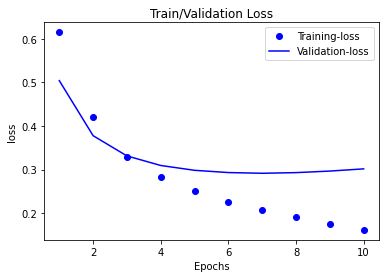

In [30]:
count = range(1,len(tr_acc) + 1)
pl.plot(count, tr_loss,'bo', label= 'Training-loss') # 'bo' is for blue dot
pl.plot(count, val_loss, 'b', label= 'Validation-loss') # 'b is for solid-blue line'

pl.title('Train/Validation Loss')
pl.xlabel('Epochs')
pl.ylabel('loss')
pl.legend()
pl.show()


> #### **Plotting `accuracy against training`** 

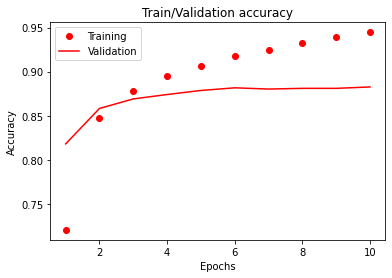

In [32]:
pl.plot(count, tr_acc, 'ro', label= 'Training')
pl.plot(count, val_acc, 'r', label= 'Validation')

pl.title('Train/Validation accuracy')
pl.xlabel('Epochs')
pl.ylabel('Accuracy')
pl.legend()
pl.show()

### **Export Model and Interface on new data** 
> **Wrap the Model into another Model, containing TextVectorization layer(since we normally pass vectorized data into the model, not the raw strings.)**

In [36]:
exp_model = tfk.Sequential([
    vec_layer,
    model,
    lyrs.Activation('sigmoid')
])

exp_model.compile(
    optimizer= opts.Adam(lr= 0.002),
    loss= losses.BinaryCrossentropy(from_logits= False),
    metrics= ['accuracy']
)

f_loss, f_acc =  exp_model.evaluate(
    raw_test_ds,
    verbose=2
)

print(f"The Final loss of the model is {f_loss}")
print(f"The Final accuracy of the model is {f_acc}")

C:\Users\ahsan\anaconda3\envs\OCR\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


782/782 - 13s - loss: 0.3340 - accuracy: 0.8663
The Final loss of the model is 0.3340160548686981
The Final accuracy of the model is 0.866320013999939


> #### **Testing the Model on self-generated data**

In [51]:
sents = [
    'The accuracy of the model is very low',
    'Loved all the scenes, will watch again with friends',
    'Horrible potrayal of the novel characters. The director hardly put any effort to match the novel, disgusted'
]

pr = exp_model.predict(sents)
print(pr)

[[0.5526544 ]
 [0.69766414]
 [0.11089897]]


### **I have finished the Notebook.. My firstever attempt with natural language processing.(Although many things are unclear)**

##### **`Things Learn't in this Notebook`**
* **Text Processing:: String => TextVectorization => EmbeddingsLayer => NeuralNetwork**
* **Keep TextVectorization Layer Out of the Core Model When Training(for better performance).**
* **Wrap up the core model along with TextVectorization layer to enable the final model to make direct pridictions on strings**
